In [57]:
set.seed(001)
library(tidyverse)
library(tidymodels)

players_url <- "https://raw.githubusercontent.com/coreyubc/project_individual/refs/heads/main/players.csv"
sessions_url <- "https://raw.githubusercontent.com/coreyubc/project_individual/refs/heads/main/sessions.csv"

── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks readr::spec()
✖ recipes::step()   masks stats::step()
• Use suppressPackageStartupMessages() to eliminate package startup messages



In [7]:
players <- read_csv(players_url)
head(players)

sessions <- read_csv(sessions_url)
head(sessions)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


hashedEmail,start_time,end_time,original_start_time,original_end_time
<chr>,<chr>,<chr>,<dbl>,<dbl>
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,30/06/2024 18:12,30/06/2024 18:24,1.71977e+12,1.71977e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,17/06/2024 23:33,17/06/2024 23:46,1.71867e+12,1.71867e+12
f8f5477f5a2e53616ae37421b1c660b971192bd8ff77e3398304c7ae42581fdc,25/07/2024 17:34,25/07/2024 17:57,1.72193e+12,1.72193e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,25/07/2024 03:22,25/07/2024 03:58,1.72188e+12,1.72188e+12
36d9cbb4c6bc0c1a6911436d2da0d09ec625e43e6552f575d4acc9cf487c4686,25/05/2024 16:01,25/05/2024 16:12,1.71665e+12,1.71665e+12
bfce39c89d6549f2bb94d8064d3ce69dc3d7e72b38f431d8aa0c4bf95ccee6bf,23/06/2024 15:08,23/06/2024 17:10,1.71916e+12,1.71916e+12


Compute the mean value for each quantitative variable in the players.csv data set. Report the mean values in a table format.

In [165]:
mean_player <- players |>
    summarize(playedhrs_avg = mean(played_hours), 
             Age_avg = mean(Age, na.rm = TRUE))
mean_player

playedhrs_avg,Age_avg
<dbl>,<dbl>
5.845918,20.52062


(2) Questions:
- I am targetting question 1: "What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?"

- Particularly, I want to answer, whether the number of played hours and age can predict whether the player is subscribed to game-related newsletter. 

- Because the end goal is to use a predictive model (like knn classification, or regression), I want my two predictive variables to be comparable. I.e. They have to be the same data type (which is easier to compute), and that's why I have chosen them to be age and played hours.

First, let's select the 3 variables that are important to us and add it to a dataframe called unscaled_data.

In [142]:
unscaled_data <- players |>
    select(Age, played_hours, subscribe) |>
    as_tibble()

head(unscaled_data)

Age,played_hours,subscribe
<dbl>,<dbl>,<lgl>
9,30.3,TRUE
17,3.8,TRUE
17,0.0,FALSE
21,0.7,TRUE
21,0.1,TRUE
17,0.0,TRUE


Next, let's use a scatter plot to plot played hours and age and use colors to differentiate between whether the player has subscribed or not. Both played hours and age are double data types and I am looking for a relationship between the two and a third variable, subscription. Therefore scatter plot is the best choice.

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


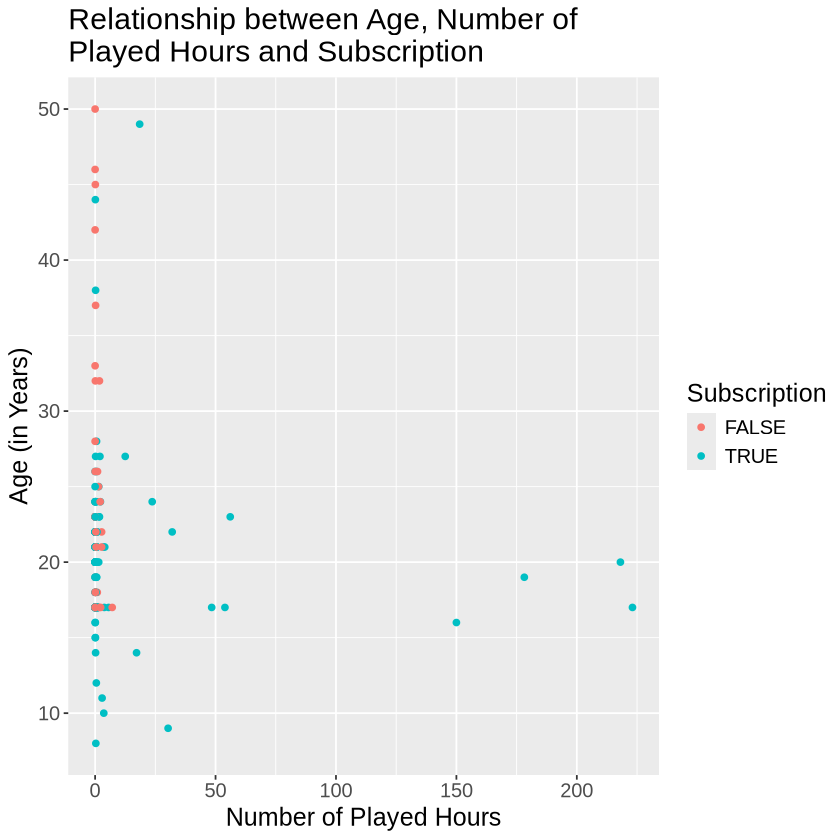

In [143]:
plot <- unscaled_data |>
    ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
    geom_point() +
    labs(x = "Number of Played Hours",
         y = "Age (in Years)",
         color = "Subscription",
        title = "Relationship between Age, Number of \nPlayed Hours and Subscription") +
    theme(text = element_text(size = 15))
plot

(1) Data Description:
Based on the tibble above and this plot generated,
- There are over 196 data points.
- The range of values for both variables are not the same and will need to be standardized.
- There are outliers such as the 4 points that are situated in the bottom right.
- Both variables are a double data type which makes them comparable after being standardized. Subscription is a logical data type and needs to be converted to a factor data type afterwards.
- So far, there are a couple issues. One, the outliers listed should be eliminated as there are not enough data points where they are situated and the predictive model will favor subscribed as an answer. Also, the bulk of the data points are situated in the far left. Two, similarly to the first point, I should limit the range of the plot to a maximum of 10 hours since that is where the bulk of the data points are situated.
- More description later.

Warning message:
“Removed 15 rows containing missing values or values outside the scale range
(`geom_point()`).”


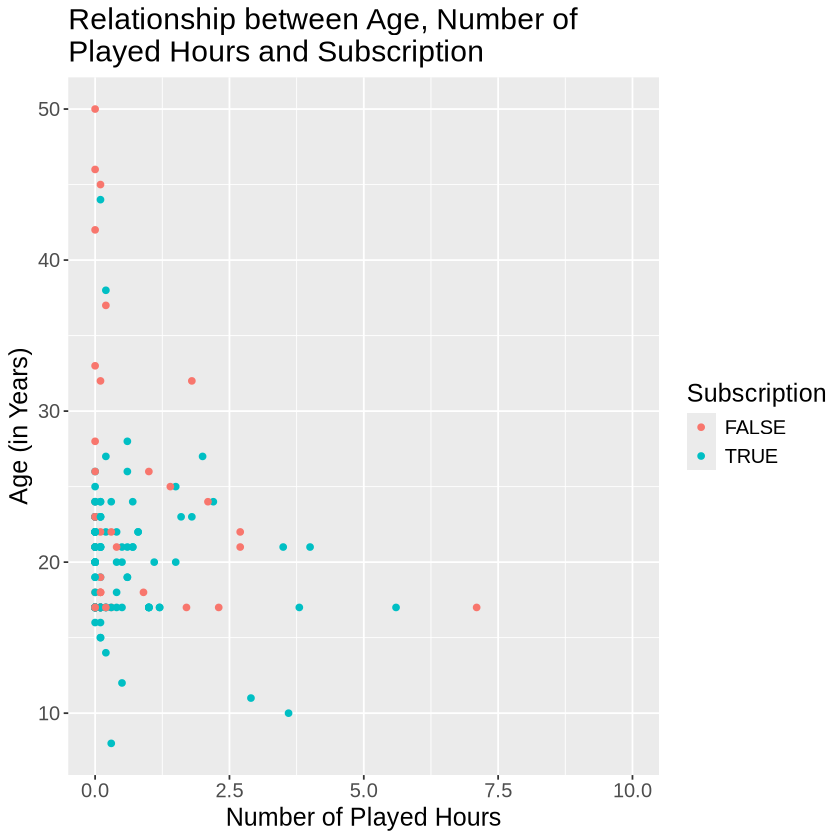

In [144]:
plot_limited <- plot + xlim(c(0), (10))
plot_limited

Looks like limiting to 10 hours seems a good ballpark. Next, I will have to change the data type from logical to factor and standardize my data points.

In [145]:
unscaled_data <- unscaled_data |>
    mutate(subscribe = as_factor(subscribe)) |>
    mutate(subscribe = fct_recode(subscribe, "Subscribed" = "TRUE", "Not_Subscribed" = "FALSE"))
head(unscaled_data)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
9,30.3,Subscribed
17,3.8,Subscribed
17,0.0,Not_Subscribed
21,0.7,Subscribed
21,0.1,Subscribed
17,0.0,Subscribed


Great, now that it has been changed to factor, I will standardize both Age and Played hours. 
* I am not using a predictive model just yet. I am simply trying to standardize it so that I can visualize how it would be after standardization.

In [111]:
data_recipe <- recipe(subscribe ~ Age + played_hours, data = unscaled_data)
data_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



In [112]:
data_recipe <- data_recipe |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    prep()
data_recipe



── Recipe ──────────────────────────────────────────────────────────────────────



── Inputs 

Number of variables by role

outcome:   1
predictor: 2



── Training information 

Training data contained 196 data points and 2 incomplete rows.



── Operations 

• Scaling for: Age and played_hours | Trained

• Centering for: Age and played_hours | Trained



In [140]:
scaled_data <- bake(data_recipe, unscaled_data)
head(scaled_data)

Age,played_hours,subscribe
<dbl>,<dbl>,<fct>
-1.86578776,0.86235447,Subscribed
-0.57017138,-0.07214775,Subscribed
-0.57017138,-0.20615184,Not_Subscribed
0.07763681,-0.18146687,Subscribed
0.07763681,-0.20262541,Subscribed
-0.57017138,-0.20615184,Subscribed


Now let's plot this scaled version. I limited the hours so that only the bulk of the data points are shown and none of the outliers. I used trial and error until it is similar to the graph from earlier.

Warning message:
“Removed 14 rows containing missing values or values outside the scale range
(`geom_point()`).”


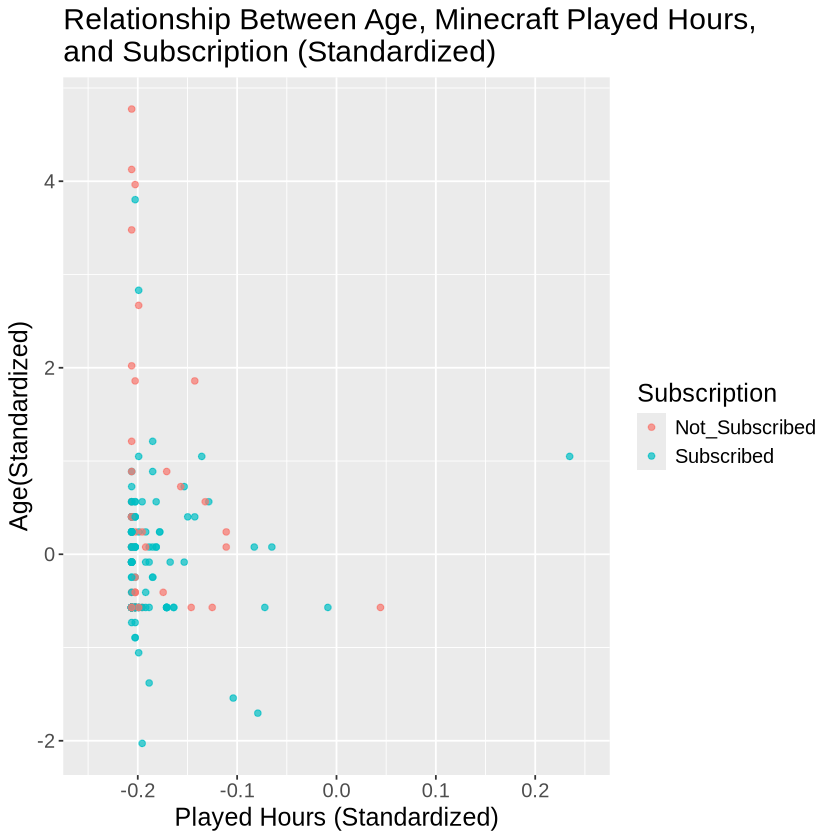

In [141]:
scaledplot <- scaled_data |>
    ggplot(aes(x = played_hours, y = Age, color = subscribe)) +
    geom_point(alpha = 0.7) +
    labs(y = "Age(Standardized)",
         x = "Played Hours (Standardized)",
         color = "Subscription",
         title = "Relationship Between Age, Minecraft Played Hours,\nand Subscription (Standardized)"
         ) +
    xlim(c(-0.25),(0.25)) +
    theme(text = element_text(size = 15))
scaledplot

(1) Data description continued... 
- It also looks like the higher in ages, the less likely it is for the player to subscribe to a newsletter. It seems from this plot alone that the number of played hours don't have much of an influence to subscription as there is no clear bias towards one or the other in the range of the played hours. However, age seems to carry more of an importance here as clearly, the younger the player, the more likely they are to be subscribed, and vice versa.

(4)
The plot generated seems like a good plot to use K-nn regression over linear regression as there is no clear linear trend. There is no assumptions here since it is clear that there is no significant linear relationship, which only leaves K-nn regression. A potential limitation or weakness of this method selected is it cannot distinguish whether a point is an outlier or not so I would have to eliminate the outliers first, which I have already done. In order to process the data to apply the model, I will split the data to 70/30 during the initial splitting. Then do cross-validation to determine the best K values. And then use that K value to predict.

Finally, I will create two histograms with both variables to see if I can find interesting findings from each one independently.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 4 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 4 rows containing missing values or values outside the scale range
(`geom_bar()`).”


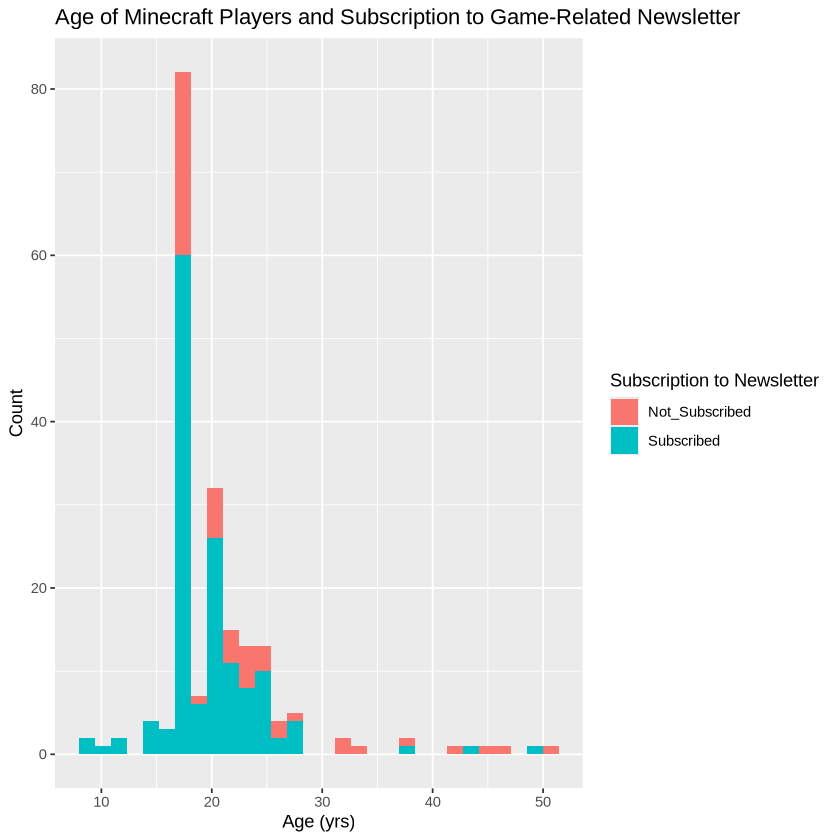

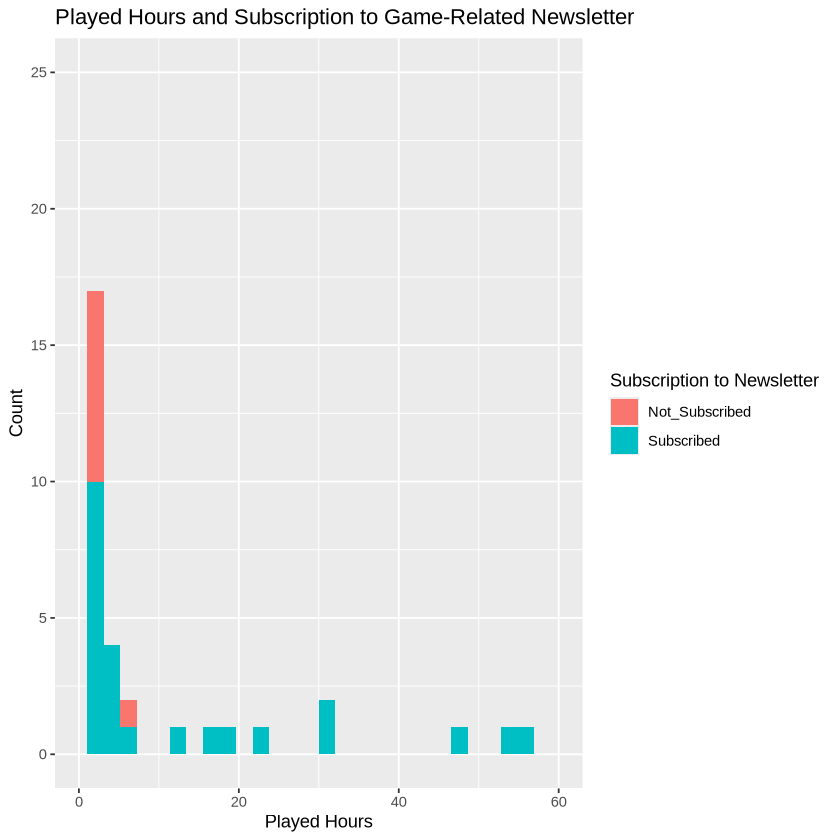

In [175]:
age_hist <- unscaled_data |>
    ggplot(aes(x = Age, fill = as_factor(subscribe))) +
    geom_histogram() +
    labs(x = "Age (yrs)",
         y = "Count",
        fill = "Subscription to Newsletter",
        title = "Age of Minecraft Players and Subscription to Game-Related Newsletter")

age_hist

playedhrs_hist <- unscaled_data |>
     ggplot(aes(x = played_hours, fill = as_factor(subscribe))) +
    geom_histogram() +
    xlim(c(0),(60))+
    ylim(c(0),(25))+
    labs(x = "Played Hours",
         y = "Count",
        fill = "Subscription to Newsletter",
        title = "Played Hours and Subscription to Game-Related Newsletter")

playedhrs_hist

(1) Description of Data continued...
- Age has more variability of subscription compared to played hours. There is an overall more players subscribed to game-related newsletter than not across both graphs. Especially for Played Hrs, it looks like only the players that play less hrs (<5 hrs) are not subscribed.